In [1]:
# Loading necessary packages
from ACDC.random_walk_classifier import * 
from ACDC.cell_type_annotation import *
import pandas as pd
import numpy as np
from collections import Counter
import pickle
import os
import phenograph
import seaborn as sns; sns.set()
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl   
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
# Setting channels to use for classification
channels = ['CD45','CD45RA', 'CD19', 'CD11b', 'CD4', 'CD8', 'CD34',
           'CD20', 'CD33', 'CD123', 'CD38', 'CD90', 'CD3']

# Loading data
path = 'data/BMMC_benchmark/'
filename = 'BMMC_benchmark.csv' # This data was downloaded from the original ACDC-developers (https://bitbucket.org/dudleylab/acdc/src/b6e98212cab060261f13760daf581ac299fc2fa3/data/BMMC_benchmark/?at=master)
df = pd.read_csv(path + filename, sep=',', header = 0)

# Read cell type-marker table
table = pd.read_csv(path + 'BMMC_table.csv', sep=',', header=0, index_col=0)
table = table[channels]
table = table.fillna(0)

# ArcSinh transformation - remember to set co-factor
c = 2.0
X0 = np.arcsinh((df[channels].values - 1.0)/c)

In [3]:
# Define some helper dictionaries
idx2ct = [key for idx, key in enumerate(table.index)]
idx2ct.append('unknown')

ct2idx = {key:idx for idx, key in enumerate(table.index)}
ct2idx['unknown'] = len(table.index)
        
ct_score = np.abs(table.as_matrix()).sum(axis = 1)

In [4]:
# Make model for markers
mk_model =  compute_marker_model(pd.DataFrame(X0, columns = channels), table, 0.0)

In [5]:
## compute posterior probs
thres = 0.5
n_neighbor = 10

score = get_score_mat(X0, [], table, [], mk_model)
score = np.concatenate([score, 1.0 - score.max(axis = 1)[:, np.newaxis]], axis = 1)

## classify events     
ct_index = get_unique_index(X0, score, table, thres)

In [6]:
## running ACDC
res_c = get_landmarks(X0, score, ct_index, idx2ct, phenograph, thres)

landmark_mat, landmark_label = output_feature_matrix(res_c, [idx2ct[i] for i in range(len(idx2ct))]) 

lp, y_pred = rm_classify(X0, landmark_mat, np.array(landmark_label), n_neighbor)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.2804839611053467 seconds
Jaccard graph constructed in 3.545258045196533 seconds
Wrote graph to binary file in 1.1945409774780273 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.708019
After 3 runs, maximum modularity is Q = 0.70983
After 4 runs, maximum modularity is Q = 0.711175
After 8 runs, maximum modularity is Q = 0.712767
Louvain completed 28 runs in 11.045358180999756 seconds
PhenoGraph complete in 18.303774118423462 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8343708515167236 seconds
Jaccard graph constructed in 1.7895638942718506 seconds
Wrote graph to binary file in 0.6263010501861572 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.666844
After 3 runs, maximum modularity is Q = 0.670347
After 7 runs, maximum modularity is Q = 0.673191
Lou

Wrote graph to binary file in 0.06449604034423828 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.658439
After 2 runs, maximum modularity is Q = 0.659784
After 4 runs, maximum modularity is Q = 0.662697
After 17 runs, maximum modularity is Q = 0.663757
After 34 runs, maximum modularity is Q = 0.664768
Louvain completed 54 runs in 0.9848318099975586 seconds
PhenoGraph complete in 1.417604923248291 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.21612882614135742 seconds
Jaccard graph constructed in 0.7257571220397949 seconds
Wrote graph to binary file in 0.3263840675354004 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.727733
After 2 runs, maximum modularity is Q = 0.729095
Louvain completed 22 runs in 1.1669139862060547 seconds
PhenoGraph complete in 2.4800469875335693 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorit

In [7]:
# Printing results to a new csv file
df = df.assign(ACDC_subtype = y_pred)

if not os.path.exists('processed_file'):
          os.makedirs('processed_file')
df.to_csv(path_or_buf='processed_file/classified_{}'.format(filename))

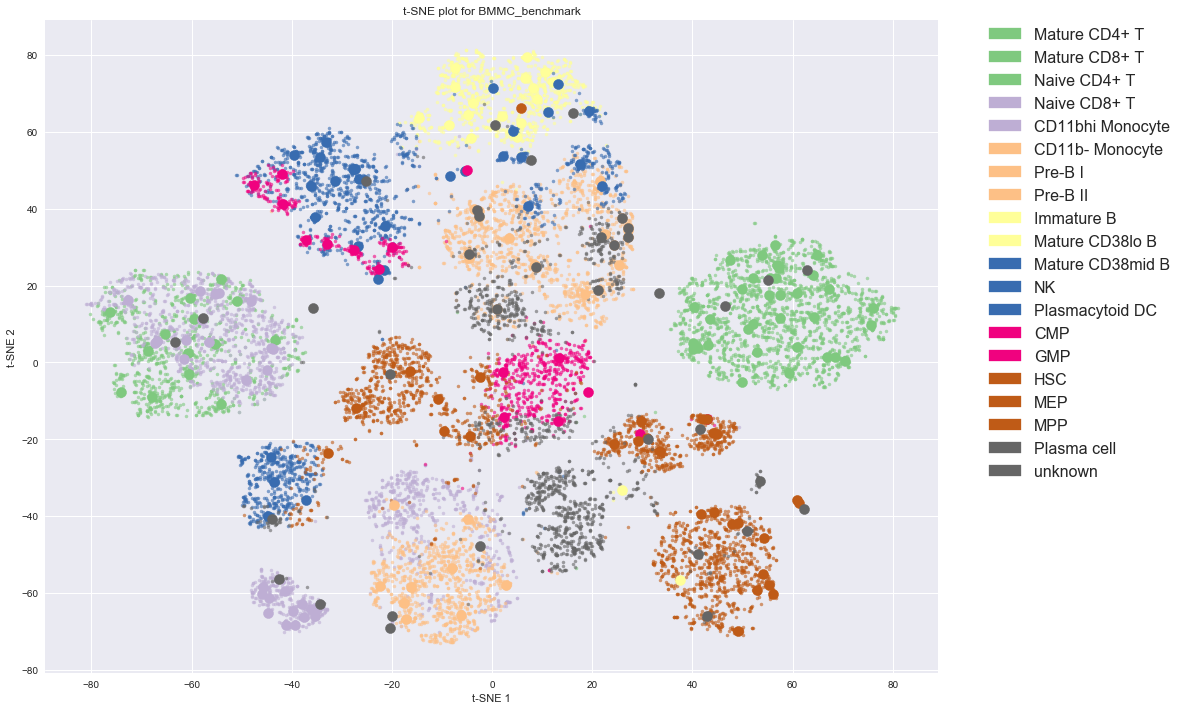

In [8]:
# Making tSNE plot for ACDC restuls
X_plot = [landmark_mat.copy()]
y_plot = landmark_label[:]

for key in idx2ct:
    tmp = X0[y_pred == key, :]
    if tmp.shape[0] > 1000:
        ## to remove randomness, we used the first 1000 events
        ## uncomment the following codes for random sampling
        
        #ind_select = np.random.choice(tmp.shape[0], 1000, replace = False)
        #tmp = tmp[ind_select, :]
        tmp = tmp[:1000, :]
        
    y_plot += [key] * tmp.shape[0]
    X_plot.append(tmp)
    
X_plot = np.vstack(X_plot) 
y_plot = np.array(y_plot)

tsne = TSNE(n_components=2, random_state=0)
Xre = tsne.fit_transform(X_plot)

cmap = mpl.cm.Accent
fig = plt.figure(1, figsize=(16, 12))

for idx, key in enumerate(idx2ct):
    plt.plot(Xre[y_plot == key, 0], Xre[y_plot == key, 1], '.',
                 color=cmap(idx / float(len(idx2ct))), alpha = 0.6, label = key)
       
for idx, key in enumerate(landmark_label):
    ax, ay = Xre[idx, 0], Xre[idx, 1]
    plt.plot(ax, ay, 'o', color=cmap(ct2idx[key] / float(len(idx2ct))),
              alpha = 1, markersize=10, markeredgewidth=0.5)
patches = []
for idx, key in enumerate(idx2ct):
    patches.append(mpatches.Patch(color=cmap(idx / float(len(idx2ct))), label=key))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size':16})

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE plot for {}'.format(os.path.splitext(filename)[0]))

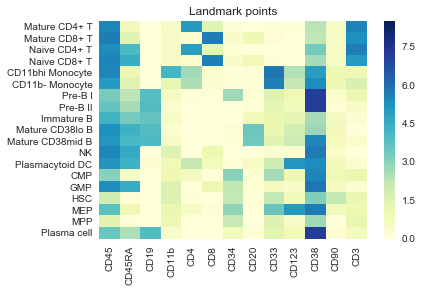

In [9]:
## Compute average profiles from each partition
ave_mat = []
for i, ct in enumerate(table.index):
    if np.any(ct_index[:, i] == 1):
        item = X0[ct_index[:, i] == 1, :]
    else:
        item = X0[score[:, i] > thres, :]
    ave_mat.append(np.mean(item, axis = 0))
ave_mat = np.vstack(ave_mat)

# Generating a heatmap of landmark points
fig = plt.figure(figsize=(6, 4))
feature_mat_df = pd.DataFrame(ave_mat, columns = table.columns, index = table.index)
ax = sns.heatmap(feature_mat_df, vmin=0.0, vmax=8.5, cmap="YlGnBu")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('Landmark points')
plt.show()